# to estimate batch effect and surrogates.
- To see if our normalization works
    - unnormalized
    - normalized by KIR_total_read(local) or 4-mer estimated coverage
    - double normalize by # of k-mer per KIR
- How to evaluate
    - pca first two components should not be strongly correlated with any surrogates
        - see the p-value, find the significant ones
        - then look at the r^2
        - use regression to determine the effect
    - plot pca and color by surrogates. --> No cluster is better
    - plot tsne and color by surrogates. --> No cluster is better
- Define surrogates:
    - coverage: KIR_total_reads, random_gene_reads
    - capture kit: coded into dummy variable
    - tumor type: (not done)
    - dataset: dbGap, TCGA, KhoeSan (not done)
## let's see what it is like before normalizing with 4-mer estimated coverage

In [19]:
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')


In [34]:
def run_pca_tsne(data):
    '''To run PCA and tSNE, return the new axis into dataframe to plot'''
    X_embedded = TSNE(n_components=2, perplexity = 5, random_state = 0).fit_transform(data)
    
    pca = PCA(n_components = 2)
    pca.fit(data)
    pca_four = PCA(n_components = 2).fit_transform(data)
    df = pd.DataFrame(X_embedded, index = data.index, columns = ['tsne1', 'tsne2'])
    df['pca1'] = [f[0] for f in pca_four]
    df['pca2'] = [f[1] for f in pca_four]
    
    
    capture_kits = pd.read_csv('/cellar/users/ramarty/Data/kir/ref/sample.capture.kit', header = 0, sep = '\t')
    capture_kits = capture_kits.loc[capture_kits['SHORT_ID'].isin(data.index.tolist())]
    capture_kits[['SHORT_ID', 'KIT']].drop_duplicates('SHORT_ID').set_index('SHORT_ID')
    
    tcga_reads = pd.read_csv('~/Data/reads_summary.csv', header = 0, index_col = 0)
    
    new_df = df.merge(capture_kits[['SHORT_ID', 'KIT']].drop_duplicates('SHORT_ID').set_index('SHORT_ID'), left_index = True, right_index = True)
    new_df = new_df.merge(tcga_reads[['KIR_total_read', 'random_total_read']], left_index = True, right_index = True)
    return(new_df, pca)

In [90]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
def kit_explain_component(pca, new_df):
    
    kit_dummies = pd.get_dummies(new_df['KIT'])
    cols = kit_dummies.columns.tolist() + ['PCA explained var %']
    # result saves here
    explain = pd.DataFrame(index = ['pca1', 'pca2'], columns = cols)
    
    # % explained by each component
    explain['PCA explained var %'] = pca.explained_variance_ratio_
    
    for pc in ['pca1', 'pca2']:
    
        regressor = LinearRegression()  
        regressor.fit(new_df[pc].values.reshape(-1,1), kit_dummies) #training the algorithm
    
        explain.loc[pc, kit_dummies.columns] = regressor.coef_.reshape(1,-1)
        
        for kit in kit_dummies.columns:
            print(kit, pc, 'corr coeff, p-value:', pearsonr(y= new_df[pc], x = kit_dummies[kit]))
    return(explain)

def coverage_explain_component(pca, new_df):
    
    explain = pd.DataFrame(index = ['pca1', 'pca2'], columns = ['KIR_total_read', 'random_total_read', 'PCA explained var %'])
    
    # % explained by each component
    explain['PCA explained var %'] = pca.explained_variance_ratio_
    
    # explain by each component
    for pc in ['pca1', 'pca2']:
        regressor = LinearRegression()
        regressor.fit(new_df[pc].values.reshape(-1,1), new_df[['KIR_total_read', 'random_total_read']]) #training the algorithm
        
        explain.loc[pc, ['KIR_total_read', 'random_total_read']] = regressor.coef_.reshape(1,-1)
        
        for var in ['KIR_total_read', 'random_total_read']:
            print(var, pc, 'corr coeff, p-value:', pearsonr(y=new_df[pc], x = new_df[var]))
    return(explain)


### Within TCGA dataset

In [4]:
unnor = pd.read_csv('~/Data/kmers/TCGA_kmers.csv', index_col=0, nrows = 1000) # kmers with selected 20 mer

In [80]:
new_df, pca = run_pca_tsne(unnor)

In [36]:
new_df.head()

,tsne1,tsne2,pca1,pca2,KIT,KIR_total_read,random_total_read
TCGA-TM-A84O,1.444988,28.712339,-102962.985528,5453.932819,Agilent Custom,25293.0,84778
TCGA-BF-AAP2,-57.270065,-48.144596,-75206.176725,3853.278343,Agilent Custom,28809.0,100561
TCGA-EJ-7794,-72.980545,-31.911606,-86178.899555,3405.541867,Agilent Custom,19507.0,101172
TCGA-CV-A45Q,-41.188320,-21.565598,-49834.552037,3119.213804,Agilent Custom,33114.0,114625
TCGA-DH-5140,51.675385,-48.114769,255105.296576,-25909.814965,Agilent Custom,68181.0,300553


In [91]:
kit_explain_component(pca, new_df)

Agilent Custom pca1 corr coeff, p-value: (0.2197260393644613, 2.4803856432449265e-09)
Nimblegen HGSC pca1 corr coeff, p-value: (-0.12943837617078302, 0.0004935286130314761)
Nimblegen hg18 pca1 corr coeff, p-value: (0.0747084067656967, 0.044925543055778575)
Nimblegen.SQEZ2 pca1 corr coeff, p-value: (-0.24983765848868264, 1.0100281370965145e-11)
Nimblegen.SQEZ3 pca1 corr coeff, p-value: (0.055611102498778764, 0.13575105447842076)
Sureselect.38 pca1 corr coeff, p-value: (0.029917309497932837, 0.42249011270513326)
Agilent Custom pca2 corr coeff, p-value: (0.15810813857038167, 1.9997437527888226e-05)
Nimblegen HGSC pca2 corr coeff, p-value: (-0.2536238051458799, 4.789784640199761e-12)
Nimblegen hg18 pca2 corr coeff, p-value: (-0.1061898537109198, 0.004310761490769805)
Nimblegen.SQEZ2 pca2 corr coeff, p-value: (0.10782525610707762, 0.003747189830479445)
Nimblegen.SQEZ3 pca2 corr coeff, p-value: (-0.08467411365982105, 0.022980312418826455)
Sureselect.38 pca2 corr coeff, p-value: (0.0842128946

,Agilent Custom,Nimblegen HGSC,Nimblegen hg18,Nimblegen.SQEZ2,Nimblegen.SQEZ3,Sureselect.38,PCA explained var %
pca1,[5.64088011429424e-07],[-2.689063213925155e-07],[7.00748659573514e-08],[-4.059631618327939e-07],[1.595084962636042e-08],[2.475575621217368e-08],0.988767
pca2,[4.911476249775327e-06],[-6.3755910162925245e-06],[-1.2052254776740342e-06],[2.1200285232411785e-06],[-2.9387690361152753e-07],[8.431886245615807e-07],0.006597


In [92]:
coverage_explain_component(pca, new_df)

KIR_total_read pca1 corr coeff, p-value: (0.903865688718195, 2.461671070812819e-267)
random_total_read pca1 corr coeff, p-value: (0.8863631249361146, 1.1806616194517335e-242)
KIR_total_read pca2 corr coeff, p-value: (0.35683462478941746, 4.491016933833688e-23)
random_total_read pca2 corr coeff, p-value: (-0.28157866313858043, 1.317786907188827e-14)


,KIR_total_read,random_total_read,PCA explained var %
pca1,[0.21529459370453177],[0.43120213645058236],0.988767
pca2,[1.028463048796681],[-1.6575301888082696],0.006597


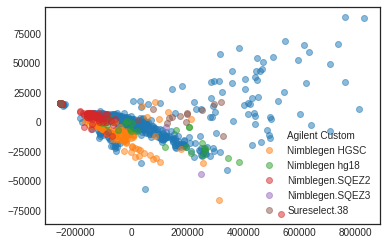

In [21]:
ax = plt.subplot()
groups = new_df.groupby(by = 'KIT')

for name, group in groups:
    ax.plot(group['pca1'], group['pca2'], label = name, marker= 'o', linestyle = '', alpha = 0.5)
ax.legend()

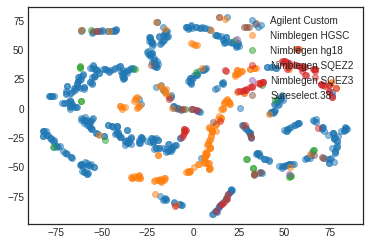

In [20]:
ax = plt.subplot()
groups = new_df.groupby(by = 'KIT')

for name, group in groups:
    ax.plot(group['tsne1'], group['tsne2'], label = name, marker= 'o', linestyle = '', alpha = 0.5)
ax.legend()

# Normalize by reads(KIR total reads or 4-mer estimated coverage)

## normalized by 4-mer estimated coverage

In [40]:
nor_four = pd.read_csv('~/Data/normalized_kmer/nor_four.csv', index_col = 0, header = 0, nrows = 1000)

In [94]:
new_nor_four, pca = run_pca_tsne(nor_four)

In [95]:
kit_explain_component(pca, new_nor_four)

Agilent Custom pca1 corr coeff, p-value: (0.4542227122968314, 1.0635254884613911e-44)
Nimblegen HGSC pca1 corr coeff, p-value: (-0.49489827479384185, 5.813970286171483e-54)
Nimblegen hg18 pca1 corr coeff, p-value: (0.036659474944981646, 0.284574021858975)
Nimblegen.SQEZ2 pca1 corr coeff, p-value: (-0.2070046428637785, 1.016756287659916e-09)
Nimblegen.SQEZ3 pca1 corr coeff, p-value: (0.01715107593339888, 0.6167136482082776)
Sureselect.38 pca1 corr coeff, p-value: (0.17523644714257872, 2.55792526357773e-07)
Agilent Custom pca2 corr coeff, p-value: (0.3364533109364522, 4.77902995620385e-24)
Nimblegen HGSC pca2 corr coeff, p-value: (-0.023363084135982724, 0.4953407799750994)
Nimblegen hg18 pca2 corr coeff, p-value: (-0.34932459666367494, 6.495475726023771e-26)
Nimblegen.SQEZ2 pca2 corr coeff, p-value: (-0.20259311249427375, 2.3176566451183616e-09)
Nimblegen.SQEZ3 pca2 corr coeff, p-value: (-0.15688710419405552, 4.093151458210125e-06)
Sureselect.38 pca2 corr coeff, p-value: (-0.085017538744

,Agilent Custom,Nimblegen HGSC,Nimblegen hg18,Nimblegen.SQEZ2,Nimblegen.SQEZ3,Sureselect.38,PCA explained var %
pca1,[101.68884588181116],[-88.21632619586157],[3.1523767995923833],[-29.575754374094792],[0.6801282745765237],[12.270729613976298],0.249581
pca2,[125.758197612509],[-6.952967932901938],[-50.151978914789275],[-48.32673413953452],[-10.387086133705266],[-9.93943049157797],0.073898


In [96]:
coverage_explain_component(pca, new_nor_four)

KIR_total_read pca1 corr coeff, p-value: (0.5702536005865165, 8.147545942858881e-75)
random_total_read pca1 corr coeff, p-value: (0.10596852932708667, 0.0019290281768684812)
KIR_total_read pca2 corr coeff, p-value: (0.1340570194991206, 8.508809175638054e-05)
random_total_read pca2 corr coeff, p-value: (0.20215132821928367, 2.514452049514185e-09)


,KIR_total_read,random_total_read,PCA explained var %
pca1,[11371543.77120075],[4453914.449408958],0.249581
pca2,[4463216.732913705],[14185628.718554365],0.073898


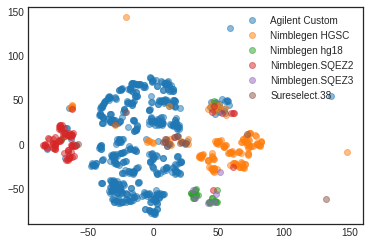

In [97]:
ax = plt.subplot()
groups = new_nor_four.groupby(by = 'KIT')

for name, group in groups:
    ax.plot(group['tsne1'], group['tsne2'], label = name, marker= 'o', linestyle = '', alpha = 0.5)
ax.legend()

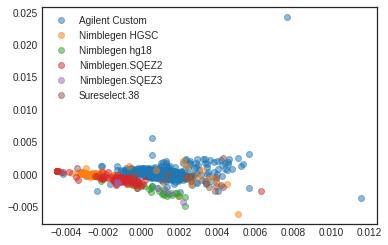

In [98]:
ax = plt.subplot()
groups = new_nor_four.groupby(by = 'KIT')

for name, group in groups:
    ax.plot(group['pca1'], group['pca2'], label = name, marker= 'o', linestyle = '', alpha = 0.5)
ax.legend()

### Normalize by total KIR reads

In [99]:
nor_read = pd.read_csv('~/Data/normalized_kmer/nor_read.csv', index_col = 0, header = 0, nrows = 1000)
new_nor_read, pca = run_pca_tsne(nor_read)

In [100]:
kit_explain_component(pca, new_nor_read)

Agilent Custom pca1 corr coeff, p-value: (-0.7361980260973101, 1.2673566531053599e-146)
Nimblegen HGSC pca1 corr coeff, p-value: (0.6671287413110014, 4.574119967737301e-111)
Nimblegen hg18 pca1 corr coeff, p-value: (0.1314108246542231, 0.00011747157630380401)
Nimblegen.SQEZ2 pca1 corr coeff, p-value: (0.22513265532864302, 2.8311553585102783e-11)
Nimblegen.SQEZ3 pca1 corr coeff, p-value: (0.05656022104317417, 0.09858011333553242)
Sureselect.38 pca1 corr coeff, p-value: (0.00271962088754722, 0.9367463017118605)
Agilent Custom pca2 corr coeff, p-value: (0.25502012877959745, 3.81732823820368e-14)
Nimblegen HGSC pca2 corr coeff, p-value: (-0.07257778695452725, 0.03395113593674585)
Nimblegen hg18 pca2 corr coeff, p-value: (-0.1388438878862285, 4.6758489346831016e-05)
Nimblegen.SQEZ2 pca2 corr coeff, p-value: (-0.21706055187001633, 1.4503316912383639e-10)
Nimblegen.SQEZ3 pca2 corr coeff, p-value: (-0.05777690295981397, 0.09153276883084872)
Sureselect.38 pca2 corr coeff, p-value: (0.0155310962

,Agilent Custom,Nimblegen HGSC,Nimblegen hg18,Nimblegen.SQEZ2,Nimblegen.SQEZ3,Sureselect.38,PCA explained var %
pca1,[-6.444673206938618],[4.649909051077108],[0.4418601160587923],[1.25775489931652],[0.08770257360190796],[0.00744656688429143],0.108136
pca2,[2.587608097151405],[-0.5863491741361421],[-0.5411257702294412],[-1.4055820942681971],[-0.10384205816506042],[0.049290999647437383],0.077664


In [102]:
coverage_explain_component(pca, new_nor_read)

KIR_total_read pca1 corr coeff, p-value: (-0.2772153185401815, 1.5638326510311121e-16)
random_total_read pca1 corr coeff, p-value: (-0.2705417785160579, 8.6221304570957615e-16)
KIR_total_read pca2 corr coeff, p-value: (0.14977712720399974, 1.1057705964445711e-05)
random_total_read pca2 corr coeff, p-value: (0.046140037807161166, 0.17794618611499974)


,KIR_total_read,random_total_read,PCA explained var %
pca1,[-216157.54335986028],[-444632.3773077829],0.108136
pca2,[135368.1383476716],[87894.65757313989],0.077664


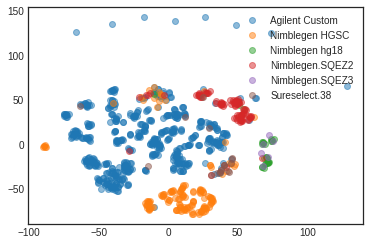

In [103]:
ax = plt.subplot()
groups = new_nor_read.groupby(by = 'KIT')

for name, group in groups:
    ax.plot(group['tsne1'], group['tsne2'], label = name, marker= 'o', linestyle = '', alpha = 0.5)
ax.legend()

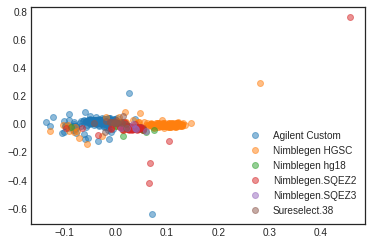

In [104]:
ax = plt.subplot()
groups = new_nor_read.groupby(by = 'KIT')

for name, group in groups:
    ax.plot(group['pca1'], group['pca2'], label = name, marker= 'o', linestyle = '', alpha = 0.5)
ax.legend()

# After double normalization
## normalize by read --> then normalize by k-mer count per KIR

In [105]:
nornor_read = pd.read_csv('~/Data/normalized_kmer/nornor_read.csv', index_col = 0, header = 0, nrows = 1000)
new_nornor_read, pca = run_pca_tsne(nornor_read)

In [106]:
kit_explain_component(pca, new_nornor_read)

Agilent Custom pca1 corr coeff, p-value: (-0.3324402938690413, 1.752313628877967e-23)
Nimblegen HGSC pca1 corr coeff, p-value: (0.1652687163553128, 1.1975028275175021e-06)
Nimblegen hg18 pca1 corr coeff, p-value: (0.05664456780620892, 0.09807799728414253)
Nimblegen.SQEZ2 pca1 corr coeff, p-value: (0.2103002714418539, 5.428297494706097e-10)
Nimblegen.SQEZ3 pca1 corr coeff, p-value: (0.030948507903956077, 0.36636215689632934)
Sureselect.38 pca1 corr coeff, p-value: (0.12596705983933648, 0.00022382393001942272)
Agilent Custom pca2 corr coeff, p-value: (0.22117610963011194, 6.355604701670367e-11)
Nimblegen HGSC pca2 corr coeff, p-value: (-0.15151107420988433, 8.713426526643378e-06)
Nimblegen hg18 pca2 corr coeff, p-value: (-0.1275764941348804, 0.00018547010948782297)
Nimblegen.SQEZ2 pca2 corr coeff, p-value: (-0.10394953259163119, 0.0023537130649767253)
Nimblegen.SQEZ3 pca2 corr coeff, p-value: (-0.06332265258568251, 0.06436522034049581)
Sureselect.38 pca2 corr coeff, p-value: (0.083180750

,Agilent Custom,Nimblegen HGSC,Nimblegen hg18,Nimblegen.SQEZ2,Nimblegen.SQEZ3,Sureselect.38,PCA explained var %
pca1,[-186.3482243873997],[73.76168189783579],[12.195996159621165],[75.23201726080333],[3.072884983108897],[22.08564408603059],0.378124
pca2,[177.24789558729097],[-96.67536171957745],[-39.270004064797334],[-53.16388209320431],[-8.988701534616705],[20.850053824904872],0.194264


In [107]:
coverage_explain_component(pca, new_nornor_read)

KIR_total_read pca1 corr coeff, p-value: (-0.054011014658001205, 0.11474527122569)
random_total_read pca1 corr coeff, p-value: (-0.1328062964261327, 9.917328031747051e-05)
KIR_total_read pca2 corr coeff, p-value: (0.17385148386935, 3.1868827118453606e-07)
random_total_read pca2 corr coeff, p-value: (0.03080496169093323, 0.36859044450685696)


,KIR_total_read,random_total_read,PCA explained var %
pca1,[-2696751.0511495788],[-13976253.164531628],0.378124
pca2,[12409897.48492038],[4634725.716133204],0.194264


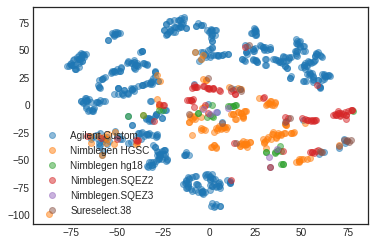

In [108]:
ax = plt.subplot()
groups = new_nornor_read.groupby(by = 'KIT')

for name, group in groups:
    ax.plot(group['tsne1'], group['tsne2'], label = name, marker= 'o', linestyle = '', alpha = 0.5)
ax.legend()

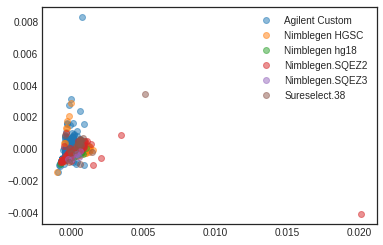

In [109]:
ax = plt.subplot()
groups = new_nornor_read.groupby(by = 'KIT')

for name, group in groups:
    ax.plot(group['pca1'], group['pca2'], label = name, marker= 'o', linestyle = '', alpha = 0.5)
ax.legend()

## first normalize by 4-mer --> normalize by kmer per/KIR

In [110]:
nornor_four = pd.read_csv('~/Data/normalized_kmer/nornor_four.csv', index_col = 0, header = 0, nrows = 1000)
new_nornor_four, pca = run_pca_tsne(nornor_four)

In [111]:
kit_explain_component(pca, new_nornor_four)

Agilent Custom pca1 corr coeff, p-value: (0.2127471135365443, 3.383731055551231e-10)
Nimblegen HGSC pca1 corr coeff, p-value: (-0.29038841683005256, 4.677212631273655e-18)
Nimblegen hg18 pca1 corr coeff, p-value: (-0.023782300998741294, 0.48763391024894964)
Nimblegen.SQEZ2 pca1 corr coeff, p-value: (-0.06632520674467975, 0.052679999386125255)
Nimblegen.SQEZ3 pca1 corr coeff, p-value: (-0.006970243883296749, 0.8388243527503846)
Sureselect.38 pca1 corr coeff, p-value: (0.2275108218884785, 1.7285484747926958e-11)
Agilent Custom pca2 corr coeff, p-value: (-0.3965920345308125, 1.4979624943582096e-33)
Nimblegen HGSC pca2 corr coeff, p-value: (0.05109369782478056, 0.13572197611487066)
Nimblegen hg18 pca2 corr coeff, p-value: (0.21187445256302492, 4.0076463433232027e-10)
Nimblegen.SQEZ2 pca2 corr coeff, p-value: (0.2750444809373388, 2.739152198795149e-16)
Nimblegen.SQEZ3 pca2 corr coeff, p-value: (0.12266440804967987, 0.00032691470911078255)
Sureselect.38 pca2 corr coeff, p-value: (0.247041970

,Agilent Custom,Nimblegen HGSC,Nimblegen hg18,Nimblegen.SQEZ2,Nimblegen.SQEZ3,Sureselect.38,PCA explained var %
pca1,[3634.6516616460513],[-3950.0897490361426],[-156.0631613729586],[-723.1510207809984],[-21.093181072464233],[1215.7454506165136],0.472676
pca2,[-12354.508513432847],[1267.293993412136],[2535.1723479749994],[5468.090489964024],[676.8540645868143],[2407.09761749487],0.186394


In [112]:
coverage_explain_component(pca, new_nornor_four)

KIR_total_read pca1 corr coeff, p-value: (0.38717316354568404, 6.301024336942788e-32)
random_total_read pca1 corr coeff, p-value: (0.0681464337935214, 0.04649627428955522)
KIR_total_read pca2 corr coeff, p-value: (-0.059548591224321566, 0.08199963026642189)
random_total_read pca2 corr coeff, p-value: (-0.11666387847492567, 0.0006355330611202942)


,KIR_total_read,random_total_read,PCA explained var %
pca1,[589184461.889889],[218576135.85909015],0.472676
pca2,[-165234182.66803923],[-682304739.2538786],0.186394


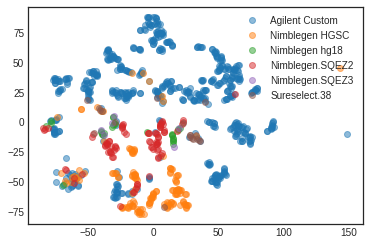

In [113]:
ax = plt.subplot()
groups = new_nornor_four.groupby(by = 'KIT')

for name, group in groups:
    ax.plot(group['tsne1'], group['tsne2'], label = name, marker= 'o', linestyle = '', alpha = 0.5)
ax.legend()

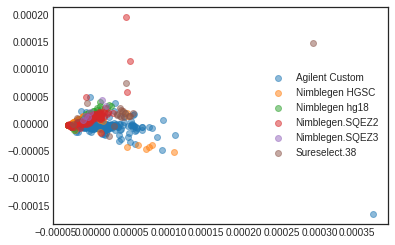

In [114]:
ax = plt.subplot()
groups = new_nornor_four.groupby(by = 'KIT')

for name, group in groups:
    ax.plot(group['pca1'], group['pca2'], label = name, marker= 'o', linestyle = '', alpha = 0.5)
ax.legend()

# if look at the sum of k-mers --> Translate into KIR copy number
The meaning of normalize by # of k-mer is to sum them up

In [115]:
kmer_df = pd.read_csv('~/Data/kmer_df', header = 0, index_col = 0)
# summing up
selected_kmer = kmer_df.loc[kmer_df['kmer'].isin(nornor_four.columns)]

def sum_up(df):
    '''
    given the double normalized kmer, return the sum by KIR dataframe
    '''
    sum_df = pd.DataFrame(index = df.index, columns = selected_kmer['gene'].unique())
    for name, group in selected_kmer.groupby(by = 'gene')['kmer']:
        sum_df[name] = df[group].sum(axis = 1)
    return(sum_df)

In [118]:
four_sum = sum_up(nornor_four)
new_four_sum, pca = run_pca_tsne(four_sum)

In [117]:
four_sum.head()

,KIR2DP1,KIR2DS4,KIR2DS5,KIR2DS2,KIR2DS3,KIR2DL1,KIR2DL5,KIR2DL4,KIR3DS1,KIR3DL2,KIR3DL3,KIR3DP1
TCGA-TM-A84O,0.000087,0.000119,2.748246e-07,0.000000e+00,3.216033e-07,0.000184,0.000026,0.000097,0.0,0.000184,0.000128,0.000098
TCGA-BF-AAP2,0.000074,0.000128,7.273845e-08,1.347575e-07,1.906676e-07,0.000156,0.000023,0.000092,0.0,0.000172,0.000119,0.000093
TCGA-EJ-7794,0.000037,0.000056,4.153698e-05,4.543834e-05,3.604531e-07,0.000084,0.000038,0.000036,0.0,0.000122,0.000091,0.000034
TCGA-CV-A45Q,0.000065,0.000054,6.626722e-05,6.779802e-05,7.537120e-05,0.000161,0.000072,0.000079,0.0,0.000142,0.000111,0.000076
TCGA-DH-5140,0.000036,0.000109,0.000000e+00,7.262263e-05,1.156209e-07,0.000081,0.000017,0.000083,0.0,0.000140,0.000106,0.000071


In [119]:
kit_explain_component(pca, new_four_sum)

Agilent Custom pca1 corr coeff, p-value: (0.22136118549783407, 6.121761461835649e-11)
Nimblegen HGSC pca1 corr coeff, p-value: (-0.39664697865645904, 1.4651193793777577e-33)
Nimblegen hg18 pca1 corr coeff, p-value: (0.04627503656811412, 0.17667897793859533)
Nimblegen.SQEZ2 pca1 corr coeff, p-value: (-0.022270246972537468, 0.5157329165386965)
Nimblegen.SQEZ3 pca1 corr coeff, p-value: (0.03557509766247188, 0.2990713177957384)
Sureselect.38 pca1 corr coeff, p-value: (0.27044618158188793, 8.832566607768382e-16)
Agilent Custom pca2 corr coeff, p-value: (-0.06285757373407792, 0.06635325963218607)
Nimblegen HGSC pca2 corr coeff, p-value: (0.031265137281377545, 0.36147680762115153)
Nimblegen hg18 pca2 corr coeff, p-value: (-0.05834043799647258, 0.0884085323181587)
Nimblegen.SQEZ2 pca2 corr coeff, p-value: (0.0654627943241804, 0.055839399126199736)
Nimblegen.SQEZ3 pca2 corr coeff, p-value: (-0.0269936456749822, 0.43079558094544224)
Sureselect.38 pca2 corr coeff, p-value: (0.07473651059476209, 0

,Agilent Custom,Nimblegen HGSC,Nimblegen hg18,Nimblegen.SQEZ2,Nimblegen.SQEZ3,Sureselect.38,PCA explained var %
pca1,[807.7938034834559],[-1152.4756320691451],[64.86243164950949],[-51.8651157114106],[22.995355845997903],[308.68915680159205],0.480101
pca2,[-363.06748738958436],[143.78667522683114],[-129.4335436526448],[241.31013252165377],[-27.617621750582565],[135.02184504432586],0.171464


In [120]:
coverage_explain_component(pca, new_four_sum)

KIR_total_read pca1 corr coeff, p-value: (0.5483484300828062, 3.3630095621458254e-68)
random_total_read pca1 corr coeff, p-value: (0.06886940517277614, 0.04421663846503172)
KIR_total_read pca2 corr coeff, p-value: (-0.1479496037500557, 1.4173791962154508e-05)
random_total_read pca2 corr coeff, p-value: (-0.005632111869908391, 0.8694564052917682)


,KIR_total_read,random_total_read,PCA explained var %
pca1,[178238931.1051495],[47183034.58001294],0.480101
pca2,[-76118543.86954723],[-6107472.363804376],0.171464


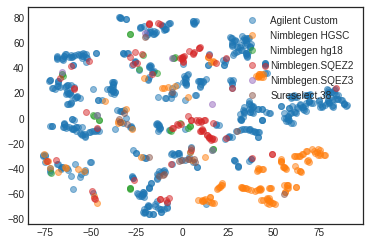

In [121]:
ax = plt.subplot()
groups = new_four_sum.groupby(by = 'KIT')

for name, group in groups:
    ax.plot(group['tsne1'], group['tsne2'], label = name, marker= 'o', linestyle = '', alpha = 0.5)
ax.legend()

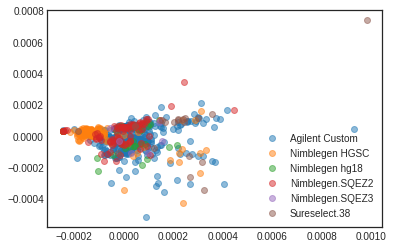

In [122]:
ax = plt.subplot()
groups = new_four_sum.groupby(by = 'KIT')

for name, group in groups:
    ax.plot(group['pca1'], group['pca2'], label = name, marker= 'o', linestyle = '', alpha = 0.5)
ax.legend()

In [123]:
read_sum = sum_up(nornor_read)
new_read_sum, pca = run_pca_tsne(read_sum)

In [124]:
kit_explain_component(pca, new_read_sum)

Agilent Custom pca1 corr coeff, p-value: (-0.2897304366869272, 5.598260959786948e-18)
Nimblegen HGSC pca1 corr coeff, p-value: (0.16437038312159705, 1.3702145651835787e-06)
Nimblegen hg18 pca1 corr coeff, p-value: (-0.011032763272605483, 0.7474897582921887)
Nimblegen.SQEZ2 pca1 corr coeff, p-value: (0.18530949191340304, 4.904734957583779e-08)
Nimblegen.SQEZ3 pca1 corr coeff, p-value: (-0.0037758618563227863, 0.9122651666041743)
Sureselect.38 pca1 corr coeff, p-value: (0.14546990667822698, 1.9758595299877796e-05)
Agilent Custom pca2 corr coeff, p-value: (-0.3414983762384763, 9.079385168984706e-25)
Nimblegen HGSC pca2 corr coeff, p-value: (0.32051989215936, 7.43098142386256e-22)
Nimblegen hg18 pca2 corr coeff, p-value: (0.045255005986631305, 0.18642150579457065)
Nimblegen.SQEZ2 pca2 corr coeff, p-value: (0.09985590219056913, 0.003487457470663971)
Nimblegen.SQEZ3 pca2 corr coeff, p-value: (0.007633188987375227, 0.8237352769676063)
Sureselect.38 pca2 corr coeff, p-value: (0.012260350150164

,Agilent Custom,Nimblegen HGSC,Nimblegen hg18,Nimblegen.SQEZ2,Nimblegen.SQEZ3,Sureselect.38,PCA explained var %
pca1,[-41.54716709736143],[18.767197249848024],[-0.607685684228247],[16.958843538130978],[-0.09590878309028046],[6.52472077670094],0.314849
pca2,[-61.770045222521254],[46.16074609680896],[3.1441504049283786],[11.526946793591017],[0.24456273323887914],[0.6936391939540527],0.208124


In [125]:
coverage_explain_component(pca, new_read_sum)

KIR_total_read pca1 corr coeff, p-value: (0.003221634744022934, 0.9251019458938374)
random_total_read pca1 corr coeff, p-value: (-0.1511203617228514, 9.196137273099451e-06)
KIR_total_read pca2 corr coeff, p-value: (-0.05362459462539233, 0.11736782478274597)
random_total_read pca2 corr coeff, p-value: (-0.17440965210481627, 2.9172745843322873e-07)


,KIR_total_read,random_total_read,PCA explained var %
pca1,[41150.0640187332],[-4068466.7576968544],0.314849
pca2,[-863973.0936239524],[-5922707.483218336],0.208124


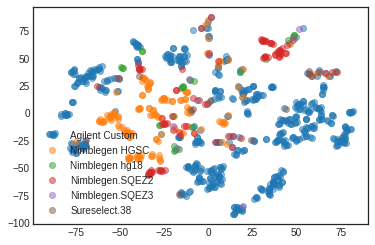

In [126]:
ax = plt.subplot()
groups = new_read_sum.groupby(by = 'KIT')

for name, group in groups:
    ax.plot(group['tsne1'], group['tsne2'], label = name, marker= 'o', linestyle = '', alpha = 0.5)
ax.legend()

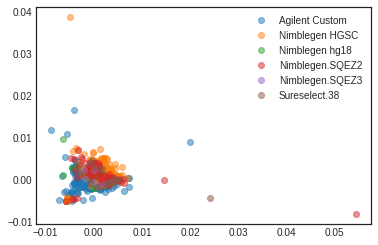

In [127]:
ax = plt.subplot()
groups = new_read_sum.groupby(by = 'KIT')

for name, group in groups:
    ax.plot(group['pca1'], group['pca2'], label = name, marker= 'o', linestyle = '', alpha = 0.5)
ax.legend()

In [133]:
color = pd.Series(index = four_sum.columns, data = 'black')
anchor_genes = ['KIR3DL3', 'KIR3DP1', 'KIR2DL4', 'KIR3DL2']
color[anchor_genes] = 'red'

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3345385b00>,
      dtype=object)

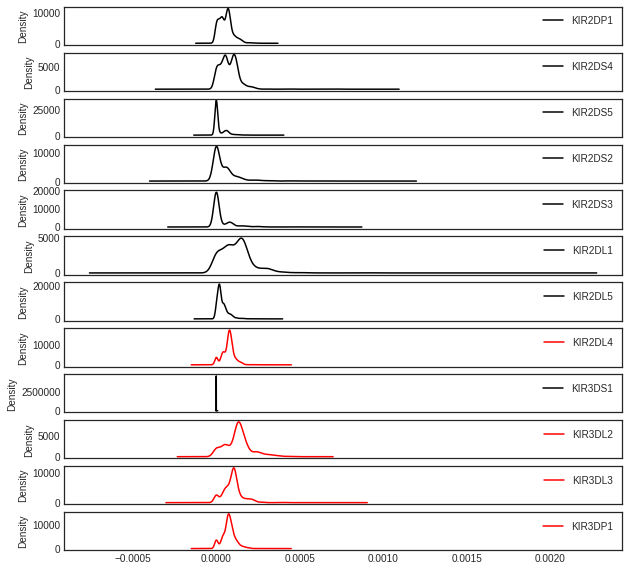

In [135]:
four_sum.plot(kind = 'kde', subplots = True, figsize = (10,10), style = color.tolist())

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3342528f98>,
      dtype=object)

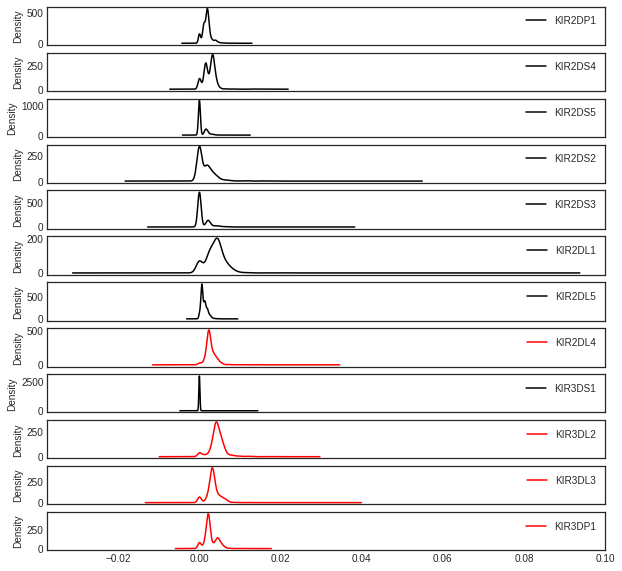

In [136]:
read_sum.plot(kind = 'kde', subplots = True, figsize = (10,10), style = color.tolist())

# What if we just sum up the un-normalized

In [138]:
unnor_sum = sum_up(unnor)
new_unnor_sum, pca = run_pca_tsne(unnor_sum)

In [140]:
kit_explain_component(pca, new_unnor_sum)

Agilent Custom pca1 corr coeff, p-value: (0.22615473217627408, 8.159649666934006e-10)
Nimblegen HGSC pca1 corr coeff, p-value: (-0.2357779477277833, 1.4496119013365436e-10)
Nimblegen hg18 pca1 corr coeff, p-value: (0.11830997681670728, 0.0014602708924901894)
Nimblegen.SQEZ2 pca1 corr coeff, p-value: (-0.1851499875198995, 5.549642941784488e-07)
Nimblegen.SQEZ3 pca1 corr coeff, p-value: (0.05811125743757631, 0.1190007979375331)
Sureselect.38 pca1 corr coeff, p-value: (0.09963440962225666, 0.007420698366258697)
Agilent Custom pca2 corr coeff, p-value: (-0.05811465569834981, 0.11897918460319072)
Nimblegen HGSC pca2 corr coeff, p-value: (-0.049010701491173335, 0.1886730533373236)
Nimblegen hg18 pca2 corr coeff, p-value: (0.21922492109042213, 2.7011043225537377e-09)
Nimblegen.SQEZ2 pca2 corr coeff, p-value: (-0.018584395600726618, 0.6183465862785831)
Nimblegen.SQEZ3 pca2 corr coeff, p-value: (0.10330924052071885, 0.00549270675181594)
Sureselect.38 pca2 corr coeff, p-value: (0.055531214278665

,Agilent Custom,Nimblegen HGSC,Nimblegen hg18,Nimblegen.SQEZ2,Nimblegen.SQEZ3,Sureselect.38,PCA explained var %
pca1,[1.1452613042281292e-06],[-9.662170661839608e-07],[2.1890099494424587e-07],[-5.934525192170711e-07],[3.28788148070095e-08],[1.6262847142164774e-07],0.838015
pca2,[-8.421261596281877e-07],[-5.747182936626485e-07],[1.1606702967489315e-06],[-1.704524758922441e-07],[1.672582819621676e-07],[2.5936835047198097e-07],0.098457


In [141]:
coverage_explain_component(pca, new_unnor_sum)

KIR_total_read pca1 corr coeff, p-value: (0.9707014087357378, 0.0)
random_total_read pca1 corr coeff, p-value: (0.6923451077083415, 5.409609028438876e-104)
KIR_total_read pca2 corr coeff, p-value: (0.0220864420544183, 0.5537862576743087)
random_total_read pca2 corr coeff, p-value: (-0.05212155714927049, 0.16209472511940226)


,KIR_total_read,random_total_read,PCA explained var %
pca1,[0.4560877932137799],[0.6643935643553865],0.838015
pca2,[0.02969484966051398],[-0.14312409477693505],0.098457


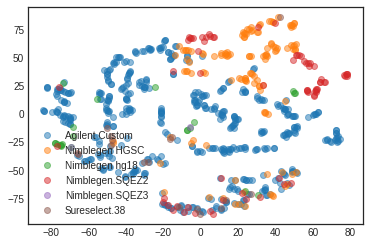

In [142]:
ax = plt.subplot()
groups = new_unnor_sum.groupby(by = 'KIT')

for name, group in groups:
    ax.plot(group['tsne1'], group['tsne2'], label = name, marker= 'o', linestyle = '', alpha = 0.5)
ax.legend()

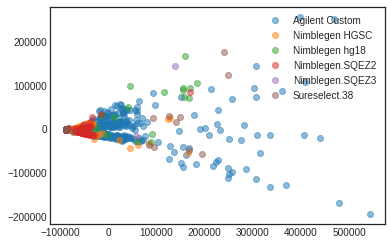

In [143]:
ax = plt.subplot()
groups = new_unnor_sum.groupby(by = 'KIT')

for name, group in groups:
    ax.plot(group['pca1'], group['pca2'], label = name, marker= 'o', linestyle = '', alpha = 0.5)
ax.legend()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3341d79668>,
      dtype=object)

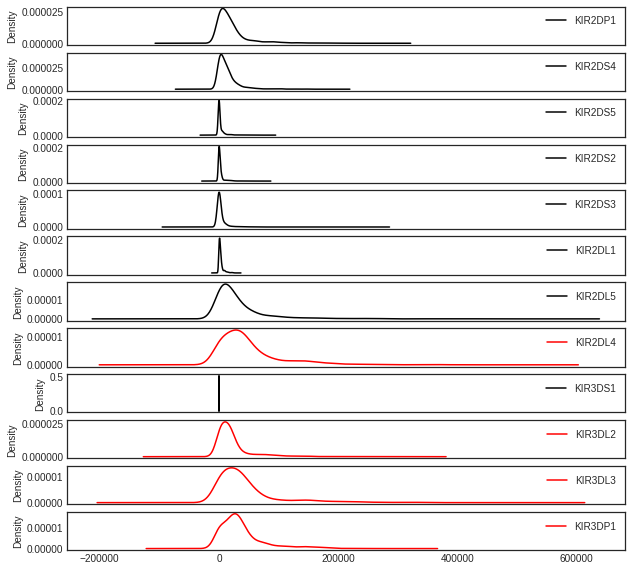

In [145]:
unnor_sum.plot(kind = 'kde', subplots = True, figsize = (10,10), style = color.tolist())